## Import

In [1]:
from yasai_funcs import yasai
import torchvision
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import os
import pandas as pd
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch import optim
from PIL import Image
import torch.nn.functional as F
import cv2
# from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
# ### for_multi_GPU
# os.environ["CUDA_VISIBLE_DEVICES"]="0,1"
# os.environ["CUDA_VISIBLE_DEVICES"]="0"

# print(torch.cuda.device_count())
# print(torch.cuda.is_available())

## Root

In [3]:
ROOT_PATH = '/home/yasaisen/Desktop/13_research/research_main/lab_02'

In [4]:
# dataset_folder = 'finetuneset_v1.0.0'

# train_img_path = os.path.join(ROOT_PATH, dataset_folder, 'finetune_train_set')
# valid_img_path = os.path.join(ROOT_PATH, dataset_folder, 'finetune_valid_set')
# test_img_path = os.path.join(ROOT_PATH, dataset_folder, 'finetune_test_set')

## Aug

In [5]:
img_size = 224
train_bsz = 32
device = 'cuda'
epochs = 30
valid_bsz = 8
test_bsz = 8
CLASSES = ['cat', 'dog']

## Dataset

In [6]:
def get_df(img_path):
    image, label = [], []

    i = 0

    for get_img_name in os.listdir(img_path):
        image += [os.path.join(img_path, get_img_name)]
        label += [get_img_name.split('.')[0]]
        
        i = i+1

    PathDF = pd.DataFrame({'image': image, 'label': label})
    print(i)
    PathDF.head()
    return PathDF

In [7]:
train_df = get_df(os.path.join(ROOT_PATH, 'dogs-vs-cats/train'))

25000


In [8]:
train_df.groupby('label').agg('size')

label
cat    12500
dog    12500
dtype: int64

In [9]:
transform = transforms.Compose([
            transforms.Resize([224,224]),
            transforms.ToTensor()
            ])

In [10]:
class mod_Dataset(Dataset):
    def __init__(self, path_df, transform=None):
        self.path_df = path_df
        self.transform = transform

    def __len__(self):
        return self.path_df.shape[0]
    
    def __getitem__(self, idx):
        if self.transform is not None:
            trans_Resize = transforms.Resize(224)

            images = trans_Resize(Image.open(self.path_df.iloc[idx]['image']).convert('RGB'))
            images = self.transform(images)

            if self.path_df.iloc[idx]['label'] == CLASSES[0]:
                lables = torch.tensor([1, 0], dtype=torch.float32)
            if self.path_df.iloc[idx]['label'] == CLASSES[1]:
                lables = torch.tensor([0, 1], dtype=torch.float32)

        return images, lables

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
validation_fraction = 0.15
test_fraction = 0.10

train2rest = validation_fraction + test_fraction
test2valid = validation_fraction / train2rest


train_df, rest = train_test_split(train_df, random_state=42,
                                 test_size = train2rest)

test_df, valid_df = train_test_split(rest, random_state=42,
                                    test_size = test2valid)

train_data = mod_Dataset(train_df, transform)
valid_data = mod_Dataset(valid_df, transform)
test_data = mod_Dataset(test_df, transform)

train_loader = DataLoader(train_data, batch_size=8, shuffle=True , num_workers=0, pin_memory=True, drop_last=True)
valid_loader = DataLoader(valid_data, batch_size=8, shuffle=False, num_workers=0)
test_loader = DataLoader(test_data, batch_size=8, shuffle=False, num_workers=0)

## Model

In [13]:
class resnet34(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.base_model = torchvision.models.resnet34()
        self.fc1 = nn.Linear(1000, num_classes)

    def forward(self, input):
        output = self.base_model(input)
        output = self.fc1(output)
        output = torch.softmax(output, dim=1)
        return output

In [14]:
model = resnet34(len(CLASSES)).to(device)
# print(model)
t = torch.randn((4, 3, 224, 224)).to(device)
print(t.shape)
get = model(t)
print(get.shape)

for x, y in train_loader:
    print(x.shape)
    print(y.shape)
    break

torch.Size([4, 3, 224, 224])
torch.Size([4, 2])
torch.Size([8, 3, 224, 224])
torch.Size([8, 2])


## Train

In [15]:
def check_accuracy(loader, model, device):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)

            scores = model(x)
            _, predictions = scores.max(1)
            _, y = y.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

    model.train()
    return (num_correct/num_samples).item()

def train(epochs, model):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)


    for epoch in range(epochs):
        model.train()
        losses = []

        pbar = tqdm(train_loader, total=len(train_loader), position=0, leave=True, desc=f"Epoch {epoch}")
        for data, targets in pbar:
            data = data.to(device)
            targets = targets.to(device)

            # forward
            scores = model(data)
            # print(scores)
            loss = criterion(scores, targets)
            losses.append(loss.item())
            # backward
            optimizer.zero_grad()
            loss.backward()

            optimizer.step()
        
        avg_loss = sum(losses) / len(losses)
        acc = check_accuracy(test_loader, model, device)
        print(f"Loss:{avg_loss:.8f}\tAccuracy:{acc:.8f}")

    return model

In [16]:
trained_resnet34_model = train(8, model)

Epoch 0: 100%|██████████| 2343/2343 [01:47<00:00, 21.83it/s]


Loss:0.62851344	Accuracy:0.71439999


Epoch 1: 100%|██████████| 2343/2343 [01:50<00:00, 21.13it/s]


Loss:0.57213758	Accuracy:0.74680001


Epoch 2: 100%|██████████| 2343/2343 [01:49<00:00, 21.31it/s]


Loss:0.53487853	Accuracy:0.76879996


Epoch 3: 100%|██████████| 2343/2343 [01:50<00:00, 21.16it/s]


Loss:0.51213112	Accuracy:0.76879996


Epoch 4: 100%|██████████| 2343/2343 [01:50<00:00, 21.11it/s]


Loss:0.49731544	Accuracy:0.80159998


Epoch 5: 100%|██████████| 2343/2343 [01:51<00:00, 21.02it/s]


Loss:0.47962709	Accuracy:0.79960001


Epoch 6: 100%|██████████| 2343/2343 [01:51<00:00, 21.07it/s]


Loss:0.46782111	Accuracy:0.79280001


Epoch 7: 100%|██████████| 2343/2343 [01:51<00:00, 21.09it/s]


Loss:0.45229975	Accuracy:0.81999999


In [17]:
yasai.model_save_v1(trained_resnet34_model, 'resnet34_trainsteprgb_2305290849_')

Successfully saved to /home/yasaisen/Desktop/13_research/research_main/lab_02/model_resnet34_trainsteprgb_2305290849_2305291720.pt


In [18]:
# trained_resnet34_model = yasai.model_load_v1('/home/yasaisen/Desktop/09_research/09_research_main/lab_11/model_resnet34_trainsteprgb_2305290849_2305291051.pt')

accuracy = 0.7485333333333334
avg_precision = 0.7486762171056875
avg_recall = 0.7485202472048598


array([[1379.,  494.],
       [ 449., 1428.]])

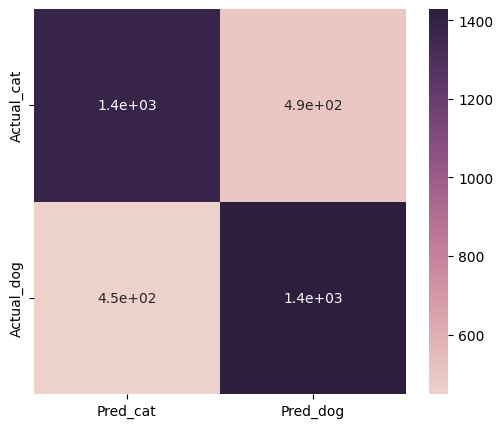

In [19]:
yasai.confusion_matrix(valid_data, trained_resnet34_model, CLASSES)

accuracy = 0.7416
avg_precision = 0.7417545126717688
avg_recall = 0.7416554877418442


array([[917., 339.],
       [307., 937.]])

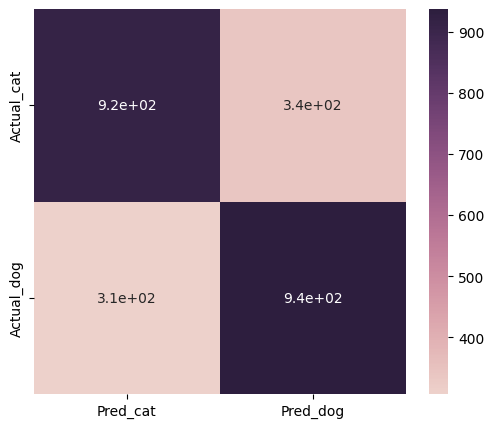

In [20]:
yasai.confusion_matrix(test_data, trained_resnet34_model, CLASSES)

accuracy = 0.7917866666666666
avg_precision = 0.7920672099140118
avg_recall = 0.7917800296501822


array([[7274., 2097.],
       [1807., 7572.]])

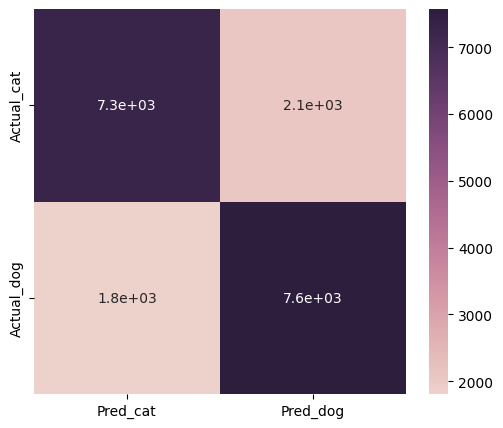

In [21]:
yasai.confusion_matrix(train_data, trained_resnet34_model, CLASSES)

In [22]:
t = torch.randn((1, 3, 224, 224)).to(device)
print(t.shape)
get = trained_resnet34_model(t)
print(get)

torch.Size([1, 3, 224, 224])
tensor([[0.5785, 0.4215]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
